Import useful tools

In [ ]:
import itertools
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import sys
import copy
import random

Prices of grocery items

In [ ]:
#Data
MRPs=dict()
MRPs[0]=20
MRPs[1]=100
MRPs[2]=50
MRPs[3]=50
MRPs[4]=100
MRPs[5]=60
MRPs[6]=35
MRPs[7]=216
MRPs[8]=27
MRPs[9]=130
MRPs[10]=160
MRPs[11]=89
MRPs[12]=73
MRPs[13]=27
MRPs[14]=185
MRPs[15]=249
MRPs[16]=199
MRPs[17]=46
MRPs[18]=55
MRPs[19]=99
'''
MRPs['chocolate']=20
MRPs['shampoo']=100
MRPs['chips']=50
MRPs['pulses']=50
MRPs['apples']=100
MRPs['grapes']=60
MRPs['pepsi']=35
MRPs['bournvita']=216
MRPs['bread']=27
MRPs['jam']=130
MRPs['buscuits']=160
MRPs['butter']=89
MRPs['toothpaste']=73
MRPs['eggs']=27
MRPs['flour']=185
MRPs['peanut_butter']=249
MRPs['cheese']=199
MRPs['milk']=46
MRPs['yoghurt']=55
MRPs['muffins']=99
'''

"\nMRPs['chocolate']=20\nMRPs['shampoo']=100\nMRPs['chips']=50\nMRPs['pulses']=50\nMRPs['apples']=100\nMRPs['grapes']=60\nMRPs['pepsi']=35\nMRPs['bournvita']=216\nMRPs['bread']=27\nMRPs['jam']=130\nMRPs['buscuits']=160\nMRPs['butter']=89\nMRPs['toothpaste']=73\nMRPs['eggs']=27\nMRPs['flour']=185\nMRPs['peanut_butter']=249\nMRPs['cheese']=199\nMRPs['milk']=46\nMRPs['yoghurt']=55\nMRPs['muffins']=99\n"

Shops, items, and rewards setup

In [ ]:
no_shops=4
no_items=2

actions=range(no_shops)

reward_buying=50

Shop randomness (availability, price bias, distance)

In [ ]:
# probability that each item is available in each shop
bernoulli=np.random.rand(no_shops,no_items)

#Price bias for each shop
bias=np.random.normal(0,5,no_shops)

#Distance Matrix
a = np.random.uniform(1,10,(no_shops,no_shops))
distance_matrix = np.tril(a) + np.tril(a, -1).T
np.fill_diagonal(distance_matrix,0)

print('Distance between shops')
distance_matrix = np.round(distance_matrix, 2)
print(distance_matrix)

Distance between shops
[[0.   7.38 6.74 5.36]
 [7.38 0.   6.25 2.49]
 [6.74 6.25 0.   6.8 ]
 [5.36 2.49 6.8  0.  ]]


### Function to add price penalty <br>
It calculates a penalty (negative reward) based on how much money the agent might spend on items in the shop it’s expected to visit next.

In [ ]:
def price_penalty(next_state):
    scaling=0.1
    shop=next_state[0]
    next_status=next_state[1]
    price=0
    for item_no in range(len(next_status)):
        if next_state[1][item_no]:
            price=price+np.random.normal(MRPs[item_no]+bias[shop],1)

    return -price*scaling

Function to add distance penalty

In [ ]:
def distance_penalty(distance):
    return -distance

Function to check item availability in shop

In [ ]:
def availability_in_shop(current_state,next_state):
    old_status=current_state[1]
    new_status=next_state[1]
    next_shop=next_state[0]

    prob=1
# If Item is bought or not
    for item_no in range(len(old_status)):
        if old_status[item_no]==0:
            if new_status[item_no]==0:
                prob=prob*(1-bernoulli[next_shop][item_no])
            else:
                prob=prob*bernoulli[next_shop][item_no]
        else:
            if new_status[item_no]==0:
                prob=0

    return prob

### Movement Probability Function <br>
Estimates how likely the agent is to move from one shop to another based on the distance between them.

In [ ]:
def M(shop_b,shop_a):
    temp=sum(sum(np.triu(distance_matrix)))
    temp2=(temp-distance_matrix[shop_b,shop_a])/((no_shops-1)*temp)
    return temp2

### State Space Creation <br>
Generates all possible situations (states) the agent can be in — combining each shop with every possible item purchase status (bought or not bought).

In [ ]:
#Creating State Space
state_space=[]
all_possible_buying_statuses=list(itertools.product([0, 1], repeat=no_items))

for shop_no in range(no_shops):
    for buying_status in all_possible_buying_statuses:
        state=(shop_no,buying_status)
        state_space.append(state)

print('State Space Size')
print(len(state_space))

State Space Size
16


#Set transition probabilities and rewards <br>
This part calculates how likely it is for the agent to move from one situation (state) to another when it takes a certain action — and also what reward or penalty the agent gets for that move.

In [ ]:
# Initialize dictionaries to store:
# P -> transition probabilities between states
# R -> rewards associated with those transitions
P = dict()
R = dict()

# All possible actions correspond to shop numbers
actions = range(no_shops)

# ------------------------------------------------
# Loop through all combinations of:
# (current_state, chosen_action, next_state)
# ------------------------------------------------
for current_state, action, next_state in list(itertools.product(state_space, actions, state_space)):

    # --------------------------------------------
    # CASE 1: If all items are already bought
    # --------------------------------------------
    # Then, there's no need to move or buy more items
    if current_state[1] == tuple(np.ones(no_items)):
        P[(current_state, action, next_state)] = 0
        R[(current_state, action, next_state)] = None
        continue

    # --------------------------------------------
    # CASE 2: If the action means staying in the same shop
    # --------------------------------------------
    if action == current_state[0]:

        # If next_state is somehow in a different shop, it’s invalid
        if next_state[0] != current_state[0]:
            P[(current_state, action, next_state)] = 0
            R[(current_state, action, next_state)] = None

        else:
            # Calculate probability of buying items in this shop
            P[(current_state, action, next_state)] = availability_in_shop(current_state, next_state)

            # Count how many items were bought
            bought_items = sum(next_state[1])

            # Calculate reward or penalty
            if bought_items > 0:
                R[(current_state, action, next_state)] = (
                    bought_items * reward_buying
                    + distance_penalty(distance_matrix[current_state[0]][next_state[0]])
                    + price_penalty(next_state)
                )
            else:
                R[(current_state, action, next_state)] = distance_penalty(distance_matrix[current_state[0]][next_state[0]])

    # --------------------------------------------
    # CASE 3: If the action means moving to a different shop
    # --------------------------------------------
    else:
        # If the agent successfully moves to the target shop
        if next_state[0] == action:
            P[(current_state, action, next_state)] = 0.9 * availability_in_shop(current_state, next_state)
            bought_items = sum(next_state[1])

            if bought_items > 0:
                R[(current_state, action, next_state)] = (
                    bought_items * reward_buying
                    + distance_penalty(distance_matrix[current_state[0]][next_state[0]])
                    + price_penalty(next_state)
                )
            else:
                R[(current_state, action, next_state)] = distance_penalty(distance_matrix[current_state[0]][next_state[0]])

        # Otherwise, agent moves indirectly (e.g., via another shop)
        else:
            P[(current_state, action, next_state)] = (
                0.1 * availability_in_shop(current_state, next_state) * M(next_state[0], current_state[0])
            )
            bought_items = sum(next_state[1])

            if bought_items > 0:
                R[(current_state, action, next_state)] = (
                    bought_items * reward_buying
                    + distance_penalty(
                        distance_matrix[current_state[0]][action] + distance_matrix[action][next_state[0]]
                    )
                    + price_penalty(next_state)
                )
            else:
                R[(current_state, action, next_state)] = distance_penalty(
                    distance_matrix[current_state[0]][action] + distance_matrix[action][next_state[0]]
                )

    # Debug print for verification (optional)
    print("Next transition:")
    print(current_state, action, next_state, P[(current_state, action, next_state)], R[(current_state, action, next_state)])


Next transition
(0, (0, 0)) 0 (0, (0, 0)) 0.2274534978491949 -0.0
Next transition
(0, (0, 0)) 0 (0, (0, 1)) 0.15527887344544608 39.01438294471757
Next transition
(0, (0, 0)) 0 (0, (1, 0)) 0.3668351354320833 46.9285544160504
Next transition
(0, (0, 0)) 0 (0, (1, 1)) 0.2504324932732757 85.8922825386849
Next transition
(0, (0, 0)) 0 (1, (0, 0)) 0 None
Next transition
(0, (0, 0)) 0 (1, (0, 1)) 0 None
Next transition
(0, (0, 0)) 0 (1, (1, 0)) 0 None
Next transition
(0, (0, 0)) 0 (1, (1, 1)) 0 None
Next transition
(0, (0, 0)) 0 (2, (0, 0)) 0 None
Next transition
(0, (0, 0)) 0 (2, (0, 1)) 0 None
Next transition
(0, (0, 0)) 0 (2, (1, 0)) 0 None
Next transition
(0, (0, 0)) 0 (2, (1, 1)) 0 None
Next transition
(0, (0, 0)) 0 (3, (0, 0)) 0 None
Next transition
(0, (0, 0)) 0 (3, (0, 1)) 0 None
Next transition
(0, (0, 0)) 0 (3, (1, 0)) 0 None
Next transition
(0, (0, 0)) 0 (3, (1, 1)) 0 None
Next transition
(0, (0, 0)) 1 (0, (0, 0)) 0.007581783261639831 -14.76
Next transition
(0, (0, 0)) 1 (0, (0, 1)

Function to take an action in environment

In [ ]:
def takeaction(current_state,action):
    global P
    global R
    global state_space
    r = random.random()
    for next_state in state_space:
        if(r<=0):
            break
        r-=P[(current_state,action,next_state)]
    return next_state, R[(current_state,action,next_state)]

Function to choose action using e-greedy

In [ ]:
def e_greedy(e,Q_s):
    x=random.randrange(1,11)
    if x<=e*10:
        return random.randrange(no_shops)
    else:
        return np.argmax(Q_s)

# **Q-learning algorithm to learn best actions**

In [ ]:
def q_learning(no_episodes,no_steps,alpha,discount,epsilon):
    Q=dict()
    Rewards=[]

    for e in range(no_episodes):
        S=random.choice(state_space)
        step=0
        Episode_Reward=0

        while(step<no_steps):
            if S not in Q.keys():
                Q[S]=np.zeros(no_shops).astype(int)
            if S[1]==tuple(np.ones(no_items)):
                break

            A=e_greedy(epsilon,Q[S])
            S_,r=takeaction(S,A)

            if S_ not in Q.keys():
                Q[S_]=np.zeros(no_shops).astype(int)

            A_=np.argmax(Q[S_])

            if r==None:
                r=0
            Q[S][A]=Q[S][A]+alpha*(r+discount*Q[S_][A_]-Q[S][A])
            S=S_
            step+=1
            Episode_Reward+=r

        Rewards.append(Episode_Reward)
    return Q,Rewards

Run Q-learning and show best policy

In [ ]:
result_Q,Rewards=q_learning(1000,200,0.1,0.9,0.5)

print("Best Policy for each state")
print("")
best_policy=dict()
for state in result_Q:
    best_action=np.argmax(result_Q[state])
    status=state[1]
    if status==tuple(np.ones(no_items)):
        best_action="End"
    best_policy[state]=best_action
    print("State",state, "Best Action",best_action)

Best Policy for each state

State (2, (1, 0)) Best Action 3
State (2, (0, 0)) Best Action 0
State (0, (1, 1)) Best Action End
State (3, (0, 0)) Best Action 3
State (1, (1, 1)) Best Action End
State (1, (0, 0)) Best Action 1
State (3, (1, 0)) Best Action 3
State (1, (1, 0)) Best Action 1
State (0, (0, 1)) Best Action 0
State (3, (1, 1)) Best Action End
State (1, (0, 1)) Best Action 3
State (2, (1, 1)) Best Action End
State (2, (0, 1)) Best Action 3
State (3, (0, 1)) Best Action 1
State (0, (1, 0)) Best Action 3
State (0, (0, 0)) Best Action 0


Plot rewards for each episode

Rewards


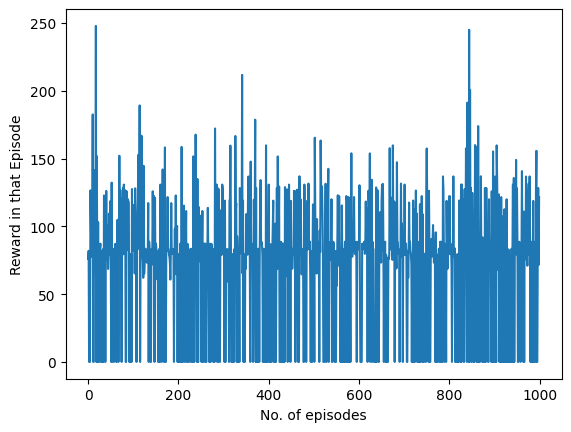

In [ ]:
print("Rewards")
plt.plot(Rewards)
plt.xlabel('No. of episodes')
plt.ylabel('Reward in that Episode')
plt.show()

Test Q-learning policy vs random policy

In [ ]:
Rewards_Qpolicy=[]
Rewards_RandomPolicy=[]
for test_no in range(100):
    print("Test no.",test_no)
    S=random.choice(state_space)
    S_random=S
    step=0
    r=0
    r_random=0

    while(S[1]!=tuple(np.ones(no_items)) and step<200):
        A=best_policy[S]
        S_,rew=takeaction(S,A)
        S=S_
        rew=R[(S,A,S_)]
        if rew==None:
            break
        r+=rew
        step+=1
    Rewards_Qpolicy.append(r)

    step=0
    while(S_random[1]!=tuple(np.ones(no_items)) and step<200):
        A_random=random.choice(actions)
        S_random_,rew=takeaction(S_random,A_random)
        S_random=S_random_
        rew=R[(S_random,A_random,S_random_)]
        if rew==None:
            break
        r_random+=rew
        step+=1
    Rewards_RandomPolicy.append(r_random)

Test no. 0
Test no. 1
Test no. 2
Test no. 3
Test no. 4
Test no. 5
Test no. 6
Test no. 7
Test no. 8
Test no. 9
Test no. 10
Test no. 11
Test no. 12
Test no. 13
Test no. 14
Test no. 15
Test no. 16
Test no. 17
Test no. 18
Test no. 19
Test no. 20
Test no. 21
Test no. 22
Test no. 23
Test no. 24
Test no. 25
Test no. 26
Test no. 27
Test no. 28
Test no. 29
Test no. 30
Test no. 31
Test no. 32
Test no. 33
Test no. 34
Test no. 35
Test no. 36
Test no. 37
Test no. 38
Test no. 39
Test no. 40
Test no. 41
Test no. 42
Test no. 43
Test no. 44
Test no. 45
Test no. 46
Test no. 47
Test no. 48
Test no. 49
Test no. 50
Test no. 51
Test no. 52
Test no. 53
Test no. 54
Test no. 55
Test no. 56
Test no. 57
Test no. 58
Test no. 59
Test no. 60
Test no. 61
Test no. 62
Test no. 63
Test no. 64
Test no. 65
Test no. 66
Test no. 67
Test no. 68
Test no. 69
Test no. 70
Test no. 71
Test no. 72
Test no. 73
Test no. 74
Test no. 75
Test no. 76
Test no. 77
Test no. 78
Test no. 79
Test no. 80
Test no. 81
Test no. 82
Test no. 83
Te

Plot comparison of Q-learning vs Random policy rewards


Rewards 


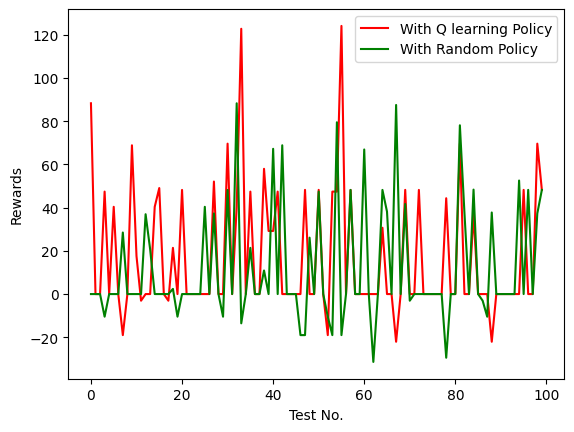

In [ ]:
print("")
print("Rewards ")
plt.plot(Rewards_Qpolicy,color='r',label='With Q learning Policy')
plt.plot(Rewards_RandomPolicy,color='g',label='With Random Policy')
plt.xlabel('Test No.')
plt.ylabel('Rewards')
plt.legend()
plt.show()